# Characterising Wikipedia Rabbit Holes

### Where do they start and where do they end?

## Setup and imports

In [17]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns

## Read and prepare data

In [43]:
read_rows = 10000  # 10 000 should run very quickly, 100 000 will take ~10s seconds, 1 000 000 will take a long time

In [35]:
all_df = pd.read_csv("data/clickstream-enwiki-2023-06.tsv", sep="\t", nrows=read_rows, names=["prev", "curr", "type", "occurrences"])
# 33 805 178 rows total
df = all_df.loc[~all_df["prev"].str.startswith("other-")]

In [36]:
# get proportions of internal vs external referrer per page 
all_df["int_or_ext_referrer"] = np.where(all_df["type"] != "link", "internal_referrer_visits", "external_referrer_visits")

ext_referrer_counts = all_df.groupby(by=["curr", "int_or_ext_referrer"])["occurrences"].sum().reset_index()
ext_referrer_counts = ext_referrer_counts.pivot(index="curr", columns="int_or_ext_referrer", values="occurrences").fillna(1).reset_index()

In [37]:
node_attributes = {node: value for node, value in zip(ext_referrer_counts["curr"].to_list(), ext_referrer_counts["external_referrer_visits"].to_list())}

## Make and explore graph

In [38]:
G = nx.from_pandas_edgelist(df=df, source="prev", target="curr", edge_attr="occurrences", create_using=nx.MultiDiGraph)
nx.set_node_attributes(G, values=node_attributes, name="ext_referrer_count")
print(G["List_of_number-one_hits_of_1973_(Mexico)"])

{'List_of_number-one_hits_of_1974_(Mexico)': {0: {'occurrences': 16}}}


<Axes: xlabel='degree', ylabel='freq'>

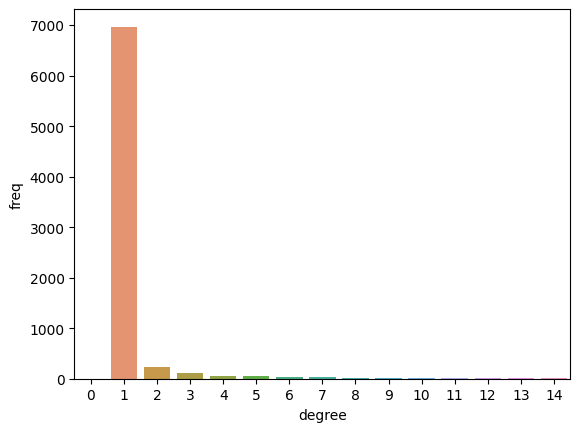

In [39]:
# histogram of node degrees 
freq = [value for i, value in enumerate(nx.degree_histogram(G))][:15]
degree = list(range(0, len(freq)))
sns.barplot(pd.DataFrame({"freq": freq, "degree": degree}), x="degree", y="freq")
# most nodes have only one connection

In [40]:
# number of distinct subgraphs
[i for i, component in enumerate(nx.weakly_connected_components(G))][-1]
# these represent nodes which connect to each other but not 

829

3324


<Axes: ylabel='Count'>

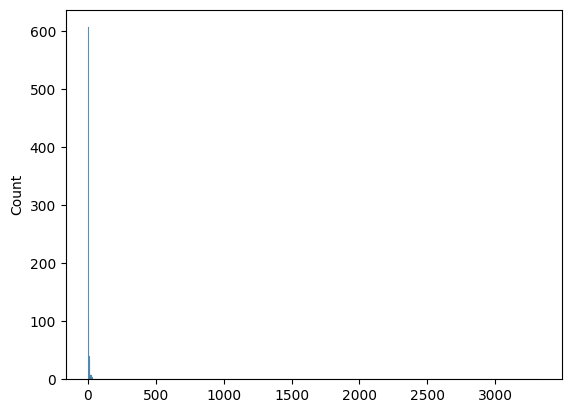

In [49]:
# size of biggest subgraph: this is the most interesting one to analyse because it will have the highest centrality values
sizes = [len(component) for i, component in enumerate(nx.weakly_connected_components(G))]
max_size = max(sizes)
print(max_size)
sns.histplot(sizes, bins=1000)

Almost all the sub graphs are tiny - just two pages connected to each other and nothing else. Will analyse the largest graph as it will have the highest centrality values

### Analyse the graph to find start and end points

In [69]:
ext_referrer_counts["int_visit_pct"] = ext_referrer_counts["internal_referrer_visits"] / (ext_referrer_counts["internal_referrer_visits"] + ext_referrer_counts["external_referrer_visits"])
all_ratios = {}
for i, comp in enumerate(nx.weakly_connected_components(G)):
    if len(comp) == max_size:
        subG = nx.subgraph(G, comp)
        nds = list(subG.nodes())
        
        # pages with lowest internal visit percentages - may indicate starting points for rabbit holes:
        props = ext_referrer_counts.loc[ext_referrer_counts["curr"].isin(nds)].sort_values(by="int_visit_pct", ascending=True)
        likely_starters = props[["curr", "int_visit_pct"]].head(10)
        likely_starters[["curr", "int_visit_pct"]].to_csv("data/likely_starting_points.csv", index=False)
        
        sub_centrality = nx.closeness_centrality(subG)
        most_central = list({k: v for k, v in sorted(sub_centrality.items(), key=lambda item: item[1])})[-1]

        out_centrality = nx.out_degree_centrality(subG)
        in_centrality = nx.in_degree_centrality(subG)
        ratios = ({node: in_value/max(out_centrality[node], 0.0001) for node, in_value in in_centrality.items()})
        sorted_ratios = [(k, v) for k, v in sorted(sub_centrality.items(), key=lambda item: item[1])]
        




In [61]:
# highest in-centrality node
print(most_central, in_centrality[most_central])

Eponym 0.09027986758952754


In [77]:
# top 10 most likely end point pages:
for name, ratio in sorted_ratios[-10:]:
    print(name, round(ratio, 5), out_centrality[name])
# they all have 0 out-centrality 

Runway_excursion 0.01956 0.0
Ansel_Adams 0.02347 0.0
Rat_Pack 0.02377 0.0
Lambeth 0.02859 0.0
Magical_girl 0.0322 0.0
Chital 0.03461 0.0
Dale_Earnhardt_Jr. 0.04093 0.0
C.F._Pachuca 0.04333 0.0
Yad_Vashem 0.04484 0.0
Eponym 0.09028 0.0


In [78]:
in_centrality["Eponym"]

0.09027986758952754

## "Eponym" is the most common end point page 